Enter a seed number (or leave blank to generate a random seed):  


Using seed: 3114
Agent 1's path: D2 -> D3 -> D4 -> D4 -> D3 -> D2 -> C2 -> B2 -> A2 -> A3
Agent 2's path: A2 -> B2 -> C2
Optimal assignment: {'Agent 1': ['A', 'C'], 'Agent 2': ['B']}
Minimum makespan: 173.0


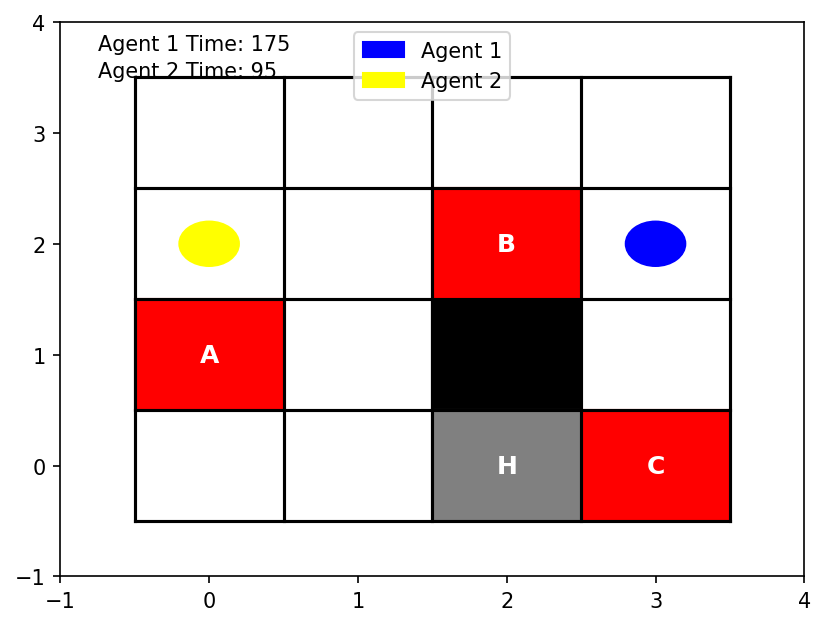

In [17]:
import heapq
import cvxpy as cp
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import matplotlib.animation as animation
from IPython.display import display, HTML

# Enable interactive mode for Jupyter Notebook animations
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
plt.ioff()

# Function to generate a random maze with agents, tasks, obstacles, and holes
def generate_maze(grid_size, num_agents, num_tasks, num_obstacles, num_holes, seed=None):
    if seed is None:
        seed = random.randint(0, 10000)
    random.seed(seed)
    
    positions = [(i, j) for i in range(grid_size) for j in range(grid_size)]
    random.shuffle(positions)
    
    agents = {f"Agent {i+1}": positions.pop() for i in range(num_agents)}
    tasks = {chr(65 + i): positions.pop() for i in range(num_tasks)}
    obstacles = {positions.pop() for _ in range(num_obstacles)}
    holes = {positions.pop() for _ in range(num_holes)}
    
    task_times = {chr(65 + i): random.randint(10, 100) for i in range(num_tasks)}
    
    return agents, tasks, obstacles, holes, task_times, seed

# Pathfinding using A* function
def a_star(start, goal, obstacles, holes, grid_size, occupied_positions):
    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])
    
    def neighbors(node):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        result = []
        for direction in directions:
            neighbor = (node[0] + direction[0], node[1] + direction[1])
            if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size and neighbor not in obstacles and neighbor not in occupied_positions:
                result.append(neighbor)
        return result
    
    frontier = []
    heapq.heappush(frontier, (0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}
    
    while frontier:
        current = heapq.heappop(frontier)[1]
        
        if current == goal:
            break
        
        for next in neighbors(current):
            new_cost = cost_so_far[current] + 1 + (10 if next in holes else 0)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(goal, next)
                heapq.heappush(frontier, (priority, next))
                came_from[next] = current
    
    # If the goal is unreachable
    if goal not in came_from:
        return None, float('inf')
    
    path = []
    current = goal
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    
    return path, cost_so_far[goal]

# Find paths and costs function
def find_paths_and_costs(agents, tasks, obstacles, holes, grid_size):
    paths = {}
    costs = {}
    
    for agent, start in agents.items():
        for task, goal in tasks.items():
            path, cost = a_star(start, goal, obstacles, holes, grid_size, set())
            if path is not None:
                paths[(agent, task)] = path
                costs[(agent, task)] = cost
    
    return paths, costs

# Solve task assignment problem using cvxpy function
def solve_task_assignment(agents, tasks, costs, task_times, grid_size, max_time):
    # Variables
    x = { (agent, task): cp.Variable(boolean=True) for agent in agents for task in tasks }
    T = { agent: cp.Variable() for agent in agents }
    Z = cp.Variable()
    
    # Constraints
    constraints = []
    
    for task in tasks:
        constraints.append(cp.sum([x[(agent, task)] for agent in agents]) == 1)

    for agent in agents:
        constraints.append(T[agent] == cp.sum([x[(agent, task)] * (costs.get((agent, task), float('inf')) + task_times[task]) for task in tasks if (agent, task) in costs]))
        constraints.append(T[agent] <= Z)

    # Collision avoidance constraints
    time_expanded_positions = { (agent, t): cp.Variable((grid_size, grid_size), boolean=True) for agent in agents for t in range(max_time) }
    
    for agent in agents:
        for t in range(max_time):
            constraints.append(cp.sum(time_expanded_positions[(agent, t)]) <= 1)
            if t > 0:
                for i in range(grid_size):
                    for j in range(grid_size):
                        neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1), (i, j)]
                        neighbors = [p for p in neighbors if 0 <= p[0] < grid_size and 0 <= p[1] < grid_size]
                        constraints.append(cp.sum([time_expanded_positions[(agent, t-1)][p[0], p[1]] for p in neighbors]) >= time_expanded_positions[(agent, t)][i, j])
    
    for t in range(max_time):
        for i in range(grid_size):
            for j in range(grid_size):
                constraints.append(cp.sum([time_expanded_positions[(agent, t)][i, j] for agent in agents]) <= 1)

    # Objective
    objective = cp.Minimize(Z)
    
    # Problem
    problem = cp.Problem(objective, constraints)
    
    # Solve the problem
    problem.solve()
    
    # Extract the results
    assignment = {agent: [] for agent in agents}
    for agent in agents:
        for task in tasks:
            if x[(agent, task)].value > 0.5:  # Binary variable check
                assignment[agent].append(task)
    
    return assignment, Z.value

# Generate path descriptions
def generate_path_descriptions(agents, tasks, assignment, task_times, obstacles, holes, grid_size):
    path_descriptions = {}
    path_costs = {}
    for agent, assigned_tasks in assignment.items():
        description = []
        start = agents[agent]
        current_obstacles = set(obstacles)
        total_cost = 0
        for task in sorted(assigned_tasks, key=lambda t: a_star(start, tasks[t], current_obstacles, holes, grid_size, set())[1]):
            path_segment, cost = a_star(start, tasks[task], current_obstacles, holes, grid_size, set())
            description += [f"{chr(65 + pos[1])}{pos[0] + 1}" for pos in path_segment]
            current_obstacles.add(tasks[task])  # Mark the task location as occupied once reached
            total_cost += cost + task_times[task]
            start = tasks[task]
        path_descriptions[agent] = " -> ".join(description)
        path_costs[agent] = total_cost
    return path_descriptions, path_costs

# Convert path descriptions to coordinates
def parse_path(path_description):
    path_coords = []
    for step in path_description.split(" -> "):
        col = ord(step[0]) - ord('A')
        row = int(step[1]) - 1
        path_coords.append((row, col))
    return path_coords

# Animate the paths using provided example
def animate_paths(agents, tasks, obstacles, holes, assignment, path_descriptions, path_costs, grid_size, interval=500):
    # Map the board positions to grid coordinates
    position_map = {f"{chr(65 + j)}{i+1}": (j, grid_size - i - 1) for i in range(grid_size) for j in range(grid_size)}

    # Convert paths to coordinates
    all_paths = {agent: parse_path(description) for agent, description in path_descriptions.items()}

    fig, ax = plt.subplots()
    ax.set_xlim(-1, grid_size)
    ax.set_ylim(-1, grid_size)

    # Draw grid lines
    for i in range(grid_size + 1):
        ax.plot([i-0.5, i-0.5], [-0.5, grid_size-0.5], color='black')
        ax.plot([-0.5, grid_size-0.5], [i-0.5, i-0.5], color='black')

    # Draw obstacles, tasks, and holes
    for obs in obstacles:
        ax.add_patch(patches.Rectangle((obs[1]-0.5, grid_size - obs[0] - 1.5), 1, 1, fill=True, color='black'))
    for task, pos in tasks.items():
        ax.add_patch(patches.Rectangle((pos[1]-0.5, grid_size - pos[0] - 1.5), 1, 1, fill=True, color='red'))
        ax.text(pos[1], grid_size - pos[0] - 1, task, ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    for hole in holes:
        ax.add_patch(patches.Rectangle((hole[1]-0.5, grid_size - hole[0] - 1.5), 1, 1, fill=True, color='grey'))
        ax.text(hole[1], grid_size - hole[0] - 1, 'H', ha='center', va='center', fontsize=12, fontweight='bold', color='white')

    # Initialize the agents' positions
    agent_markers = {}
    colors = {'Agent 1': 'blue', 'Agent 2': 'yellow'}
    for agent in agents:
        start_pos = all_paths[agent][0]
        marker = patches.Circle((start_pos[1], grid_size - start_pos[0] - 1), 0.2, color=colors[agent], label=agent)
        ax.add_patch(marker)
        agent_markers[agent] = marker

    # Display the total cost/time for each agent
    time_texts = {agent: ax.text(0.05, 0.95 - idx * 0.05, '', transform=ax.transAxes) for idx, agent in enumerate(agents)}

    def animate(i):
        for agent, path in all_paths.items():
            if i < len(path):
                pos = path[i]
                agent_markers[agent].center = (pos[1], grid_size - pos[0] - 1)
            time_texts[agent].set_text(f"{agent} Time: {path_costs[agent]}")
        return list(agent_markers.values()) + list(time_texts.values())

    max_frames = max(len(path) for path in all_paths.values())
    ani = animation.FuncAnimation(fig, animate, frames=max_frames, interval=interval, blit=True)

    plt.legend()
    plt.show()
    display(HTML(ani.to_jshtml()))

# Main execution
def main():
    grid_size = 4
    num_agents = 2
    num_tasks = 3
    num_obstacles = 1
    num_holes = random.randint(1, 3)
    
    seed_input = input("Enter a seed number (or leave blank to generate a random seed): ")
    seed = int(seed_input) if seed_input else None
    
    agents, tasks, obstacles, holes, task_times, used_seed = generate_maze(grid_size, num_agents, num_tasks, num_obstacles, num_holes, seed)
    print(f"Using seed: {used_seed}")
    
    paths, costs = find_paths_and_costs(agents, tasks, obstacles, holes, grid_size)
    
    # Estimate max_time as a heuristic
    max_time = grid_size * grid_size
    
    assignment, min_time = solve_task_assignment(agents, tasks, costs, task_times, grid_size, max_time)
    
    path_descriptions, path_costs = generate_path_descriptions(agents, tasks, assignment, task_times, obstacles, holes, grid_size)
    for agent, description in path_descriptions.items():
        print(f"{agent}'s path: {description}")
    
    print(f"Optimal assignment: {assignment}")
    print(f"Minimum makespan: {min_time}")

    animate_paths(agents, tasks, obstacles, holes, assignment, path_descriptions, path_costs, grid_size)

# Run the main function
if __name__ == "__main__":
    main()
